## Order supply Analysis
### Agenda
- Introduction
- Posing questions
- Data load and correction
- Analysis
  - Order & Operational Insights
  - Market & Customer Trends
  - Financial Insights
- Conclusion


### Introduction
The purpose of this analysis is to explore and understand the company’s order dataset, spanning the period from **2015 to 2018**. The dataset contains transactional details, including *order information, customer segments, product details, shipping data, and financial metrics.*  
  
Before performing any deeper analysis, the dataset undergoes basic cleaning and normalization, such as handling missing values, correcting data types, capping extreme profits, and standardizing country names to ISO3 codes. This ensures that subsequent analysis is accurate and reliable.   
  
The exploration aims to determine operational insights, such as order size distribution, delivery performance, and seasonality trends, as well as financial and market insights. Additionally, relationships between variables, such as GDP, shipping mode, and delays, are investigated to identify key factors impacting operations and profitability

### Posing questions
- Which *order sizes, customer segments, or markets* drive the most **sales** and **profit**?
- How are **delivery delays** influenced by *shipping mode, order size, or payment type*?
- Are there seasonal patterns in order volumes throughout the year?
- Is there a relationship or co-movement between **GDP values** and *order indicators*?
- How concentrated are **profits** and orders across *countries*?
- Which **products** are most/least popular *overall* and within each *customer segment*?
- How do **profit margins** vary by *market, segment, or payment type*?

### Data load & correction

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [68]:
#Load data
file_path1 = 'transformed\orders_cleaned.csv'
orders_df = pd.read_csv(file_path1)

file_path2 = 'transformed\gdp_cleaned.csv'
gdp_df = pd.read_csv(file_path2)

In [69]:
#Correct datatypes
orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'], errors='coerce')
orders_df['Shipping_Date'] = pd.to_datetime(orders_df['Shipping_Date'], errors='coerce')
orders_df['Year'] = orders_df['Order_Date'].dt.year
orders_df['Year'].value_counts()

Year
2015    62646
2016    62546
2017    53194
2018     2123
Name: count, dtype: int64

In [70]:
#Merge datasets
df = pd.merge(orders_df, gdp_df, on=['ISO3', 'Year'], how='left')
df.drop(columns='Country', inplace=True)

#Quick check for successful merging
orders_keys = orders_df[['ISO3', 'Year']].drop_duplicates().shape[0]
merged_keys = df[['ISO3', 'Year']].drop_duplicates().shape[0]

if orders_keys==merged_keys:
    print('The merging is successful!') 
else:
    print('The merging has some issues.')

The merging is successful!


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180509 entries, 0 to 180508
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Order_Id             180509 non-null  int64         
 1   Order_Date           180509 non-null  datetime64[ns]
 2   Order_Status         180509 non-null  object        
 3   Order_Region         180509 non-null  object        
 4   Market               180509 non-null  object        
 5   ISO3                 180100 non-null  object        
 6   Customer_Segment     180509 non-null  object        
 7   Product_Id           180509 non-null  int64         
 8   Product_Name         180509 non-null  object        
 9   Category_Name        180509 non-null  object        
 10  Product_Price        180509 non-null  float64       
 11  Shipping_Date        180509 non-null  datetime64[ns]
 12  Shipping_Mode        180509 non-null  object        
 13  Shipment(real)

### Analysis

#### Orders

##### Order Categories
After categorizing orders by size, the sales analysis shows that the majority of orders are small, generating proportionally low profits. Larger orders tend to include more items. The most frequently sold orders are both small and very large categories.

In [72]:
#Order categories by sales volume
order_value = (
    df.groupby('Order_Id', as_index=False).agg(
        Order_Sales=('Sales', 'sum'),
        Order_Profit=('Profit_Capped', 'sum'),
        Item_Count=('Item_Quantity', 'sum'),
        Order_Date=('Order_Date', 'first'),
        Order_Region=('Order_Region', 'first'),
        Market=('Market', 'first'),
        Customer_Segment=('Customer_Segment', 'first'))
)

order_value['Order_Size'] = pd.qcut(
    order_value['Order_Sales'],
    q=[0, 0.5, 0.8, 0.95, 1.0],
    labels=['Small', 'Medium', 'Large', 'Very Large'])

category_table = order_value.groupby('Order_Size').agg(
    Orders=('Order_Id', 'count'),
    Avg_Sales=('Order_Sales', 'mean'),
    Total_Sales=('Order_Sales', 'sum'),
    Avg_Profit=('Order_Profit', 'mean'),
    Avg_Items=('Item_Count', 'mean'))

print(f'Order categories based on the sales volume: \n{category_table}')

Order categories based on the sales volume: 
            Orders    Avg_Sales   Total_Sales  Avg_Profit  Avg_Items
Order_Size                                                          
Small        32876   269.275297  8.852695e+06   31.548448   3.141988
Medium       19725   680.116156  1.341529e+07   77.135064   7.645577
Large         9881  1012.882762  1.000829e+07  115.543054   9.922579
Very Large    3269  1378.447513  4.506145e+06  156.906860   9.760783


##### Order Categories overview
*Small* orders are the most frequent, spread across all customer segments and markets, but generate modest total sales.   
*Medium* orders produce the highest total sales due to a balance of volume and value.    *Large* and *Very Large* orders are rarer but highly profitable per order, with Europe and LATAM being the dominant markets.   
Overall, as order size increases, the number of orders decreases while per-order value grows.

Quick view on categories:
 Small 
Date range: 
  2015-01-01 00:00:00 - 2018-01-31 00:00:00
The number of unique customer segments: 
 {'Consumer': 17115, 'Corporate': 9821, 'Home Office': 5940}
The number of unique markets: 
 {'Pacific Asia': 10501, 'Europe': 9218, 'LATAM': 7581, 'USCA': 3858, 'Africa': 1718}
Total sales: 
 8852694.678879999


Quick view on categories:
 Medium 
Date range: 
  2015-01-01 00:00:00 - 2018-01-02 00:00:00
The number of unique customer segments: 
 {'Consumer': 10122, 'Corporate': 6075, 'Home Office': 3528}
The number of unique markets: 
 {'LATAM': 5778, 'Europe': 5292, 'Pacific Asia': 4459, 'USCA': 2884, 'Africa': 1312}
Total sales: 
 13415291.183910001


Quick view on categories:
 Large 
Date range: 
  2015-01-01 00:00:00 - 2017-10-02 00:00:00
The number of unique customer segments: 
 {'Consumer': 5135, 'Corporate': 2970, 'Home Office': 1776}
The number of unique markets: 
 {'LATAM': 2994, 'Europe': 2865, 'Pacific Asia': 1969, 'USCA': 1419, 'Africa': 634}
To

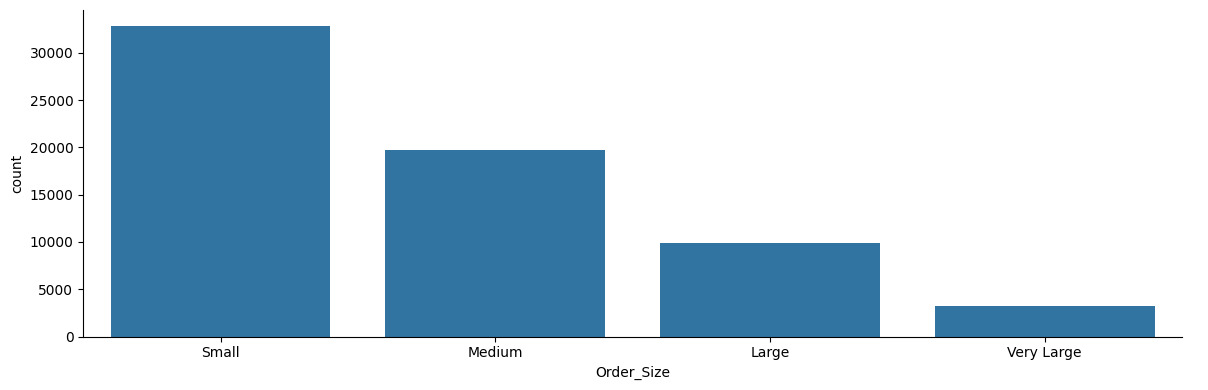

In [73]:
#Order category
categories = order_value['Order_Size'].unique().tolist()

for category in categories:
    selected = order_value.loc[order_value['Order_Size']==category]
    selected['Order_Date'] = selected['Order_Date'].sort_values()

    min_date = selected.iloc[0, selected.columns.get_loc("Order_Date")]
    max_date = selected.iloc[-1, selected.columns.get_loc("Order_Date")]

    customer_segment = selected['Customer_Segment'].value_counts().to_dict()

    market = selected['Market'].value_counts().to_dict()

    sales = selected['Order_Sales'].dropna().sum()

    avg_price = selected

    print(f'Quick view on categories:\n {category} ')
    print(f'Date range: \n  {min_date} - {max_date}')
    print(f'The number of unique customer segments: \n {customer_segment}')
    print(f'The number of unique markets: \n {market}')
    print(f'Total sales: \n {sales}\n\n')

plot = sns.catplot(x='Order_Size', kind='count', data=order_value, height=4, aspect=3)

##### Delivery quality
Most deliveries experienced only slight delays, while severe delays were rare.

Delivery Quality: 
{'Slight Delay': 96411, 'Early': 43365, 'On Time': 33750, 'Severe Delay': 6983}


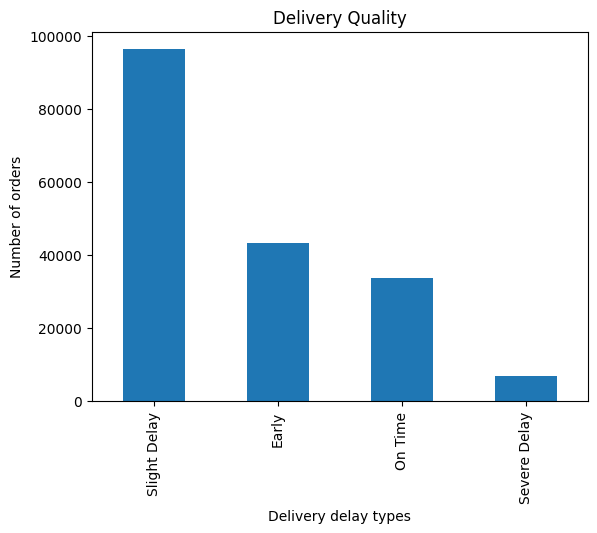

In [74]:
#Delivery quality
df['Delay_Days'] = df['Shipment(real)'] - df['Shipment(scheduled)']

def delay_label(x):
    if x==0:
        return 'On Time'
    elif x <= -1:
        return 'Early'
    elif 1 <= x <= 3:
        return 'Slight Delay'
    else:
        return 'Severe Delay'
    
df['Delivery_Quality'] = df['Delay_Days'].apply(delay_label) 
category_counts = df['Delivery_Quality'].value_counts().to_dict()

print(f'Delivery Quality: \n{category_counts}')

df['Delivery_Quality'].value_counts().plot(kind='bar')
plt.xlabel('Delivery delay types')
plt.ylabel('Number of orders')
plt.title('Delivery Quality')
plt.show()

##### Delay factors
Factor analysis shows that **shipping mode** has the greatest impact on delivery delays, while GDP, order size, and order year have **negligible** effects.   
Average delivery delays are similar across payment types, with PAYMENT showing a slightly higher delay, indicating payment method has **minimal** impact on delivery time.

In [75]:
#Delay factors 

#Create/correct columns
df['GDP_per_capita'] = df['GDP'] / df['Population']
df['Order_Year'] = df['Order_Date'].dt.year.astype('object')

#Function
def delay_factors(df, factor_list):
    report = {}
    
    for f in factor_list:
        if df[f].dtype.name in ['category', 'object']:
            report[f] = df.groupby(f)['Delay_Days'].mean()
        else:
            quartiles = pd.qcut(df[f], 4, duplicates='drop')
            report[f] = df.groupby(quartiles)['Delay_Days'].mean()
    
    return report

#Usage
factors = ['Shipping_Mode','Item_Quantity', 'GDP_per_capita', 'Order_Year']
factors_dict = delay_factors(df, factors)

for factor, delays in factors_dict.items():
    print(f'\nAverage delay by {factor}:')
    print(delays.round(2))


Average delay by Shipping_Mode:
Shipping_Mode
First Class       1.00
Same Day          0.48
Second Class      1.99
Standard Class   -0.00
Name: Delay_Days, dtype: float64

Average delay by Item_Quantity:
Item_Quantity
(0.999, 3.0]    0.56
(3.0, 5.0]      0.57
Name: Delay_Days, dtype: float64

Average delay by GDP_per_capita:
GDP_per_capita
(232.93699999999998, 5710.599]    0.57
(5710.599, 14082.655]             0.56
(14082.655, 45255.345]            0.55
(45255.345, 110193.214]           0.58
Name: Delay_Days, dtype: float64

Average delay by Order_Year:
Order_Year
2015    0.56
2016    0.57
2017    0.56
2018    0.61
Name: Delay_Days, dtype: float64


CASH: 0.55
DEBIT: 0.56
PAYMENT: 0.59
TRANSFER: 0.56


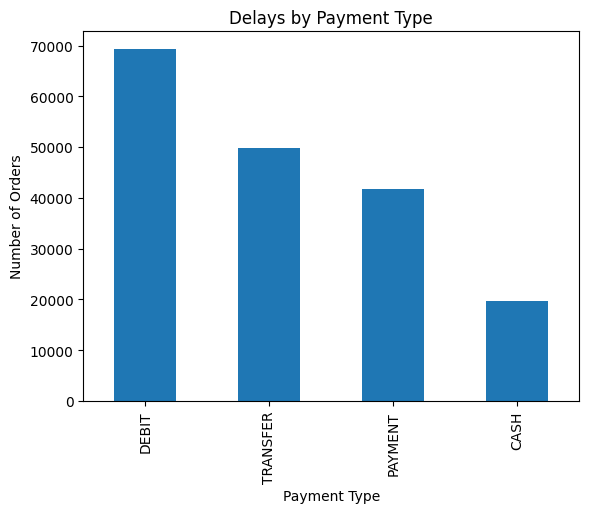

In [76]:
#Delay by payment type

payment_delay = df.groupby('Payment_Type')['Delay_Days'].mean()
for type, delay in payment_delay.items():
    print(f'{type}: {delay:.2f}')

df['Payment_Type'].value_counts().plot(kind='bar')
plt.xlabel('Payment Type')
plt.ylabel('Number of Orders')
plt.title('Delays by Payment Type')
plt.show()

##### Order Status analysis
Most orders are either COMPLETE or PENDING_PAYMENT, accounting for the majority of item volume and profit. Canceled or flagged orders contribute little to revenue.   
Overall, order completion strongly drives both total profit and item quantity, highlighting the importance of monitoring pending payments to maximize revenue.

Number of orders by Order Status:
  CANCELED: 3692
  CLOSED: 19615
  COMPLETE: 59488
  ON_HOLD: 9804
  PAYMENT_REVIEW: 1893
  PENDING: 20224
  PENDING_PAYMENT: 39831
  PROCESSING: 21902
  SUSPECTED_FRAUD: 4060

Profit by Order Status:
  CANCELED: 84635.48
  CLOSED: 485969.44
  COMPLETE: 1393836.43
  ON_HOLD: 224302.04
  PAYMENT_REVIEW: 45142.95
  PENDING: 463704.48
  PENDING_PAYMENT: 906905.41
  PROCESSING: 519624.44
  SUSPECTED_FRAUD: 89164.69

Item quantity by Order Status:
  CANCELED: 7875
  CLOSED: 41455
  COMPLETE: 126620
  ON_HOLD: 20845
  PAYMENT_REVIEW: 4109
  PENDING: 43189
  PENDING_PAYMENT: 84735
  PROCESSING: 46623
  SUSPECTED_FRAUD: 8607


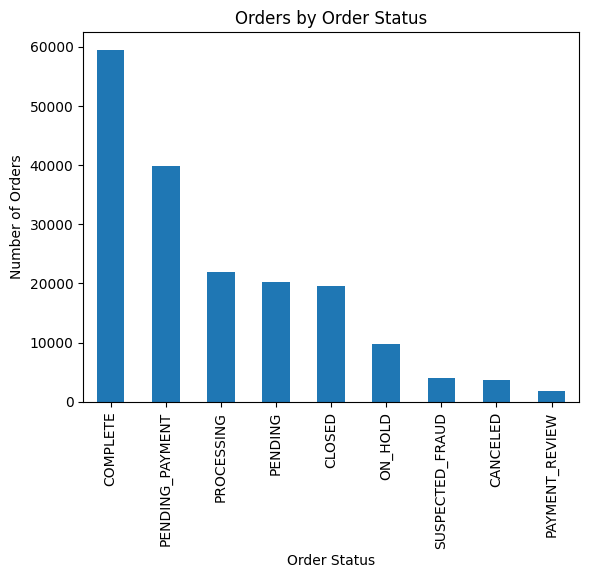

In [77]:
#Order Status analysis
status_orders = df.groupby('Order_Status')['Order_Id'].count()
status_profit = df.groupby('Order_Status')['Profit_Capped'].sum()
status_items = df.groupby('Order_Status')['Item_Quantity'].sum()

print("Number of orders by Order Status:")
for status, orders in status_orders.items():
    print(f"  {status}: {orders}")

print("\nProfit by Order Status:")
for status, profit in status_profit.items():
    print(f"  {status}: {profit:.2f}")

print("\nItem quantity by Order Status:")
for status, quantity in status_items.items():
    print(f"  {status}: {quantity}")

df['Order_Status'].value_counts().plot(kind='bar')
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.title('Orders by Order Status')
plt.show()

#### Market & Customer Trends

##### Market Trends
**Europe** and **LATAM** are the top markets in terms of order volume, sales, and profit, followed by Pacific Asia.   
USCA and Africa contribute less to overall revenue.   
Delivery performance is consistent across all markets, with average delays around 0.56–0.57 days.

For Pacific Asia market:
Order volume: 41259
Sales volume: 8273623.79
Total profit: 913974.22
Average delay: 0.57 days

For USCA market:
Order volume: 25797
Sales volume: 5066208.76
Total profit: 600532.10
Average delay: 0.57 days

For Africa market:
Order volume: 11612
Sales volume: 2293852.97
Total profit: 271788.46
Average delay: 0.56 days

For Europe market:
Order volume: 50251
Sales volume: 10872096.88
Total profit: 1226903.89
Average delay: 0.57 days

For LATAM market:
Order volume: 51590
Sales volume: 10276642.95
Total profit: 1200086.69
Average delay: 0.56 days



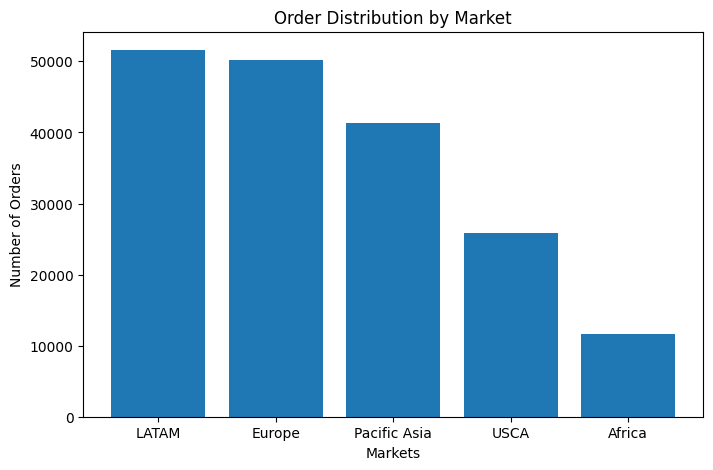

In [78]:
#Market trends
markets = df['Market'].unique().tolist()
market_counts = df['Market'].value_counts()

for market in markets:
    selected = df.loc[df['Market']==market]

    order_volume = len(selected)
    sales = selected['Sales'].sum()
    profit = selected['Profit_Capped'].sum()
    delays = round(selected['Delay_Days'].mean(), 2)

    print(f'For {market} market:')
    print(f'Order volume: {order_volume}')
    print(f'Sales volume: {sales:.2f}')
    print(f'Total profit: {profit:.2f}')
    print(f'Average delay: {delays} days\n')

plt.figure(figsize=(8,5))
plt.bar(market_counts.index, market_counts.values)
plt.title('Order Distribution by Market')
plt.xlabel('Markets')
plt.ylabel('Number of Orders')
plt.show()


##### Monthly seasonality
To analyze monthly seasonality, order months were extracted and properly ordered.   
The chart shows a peak in orders in *January* (~18,000), relatively stable activity from *March* to *September*, and a notable decline from *October* to *December*.

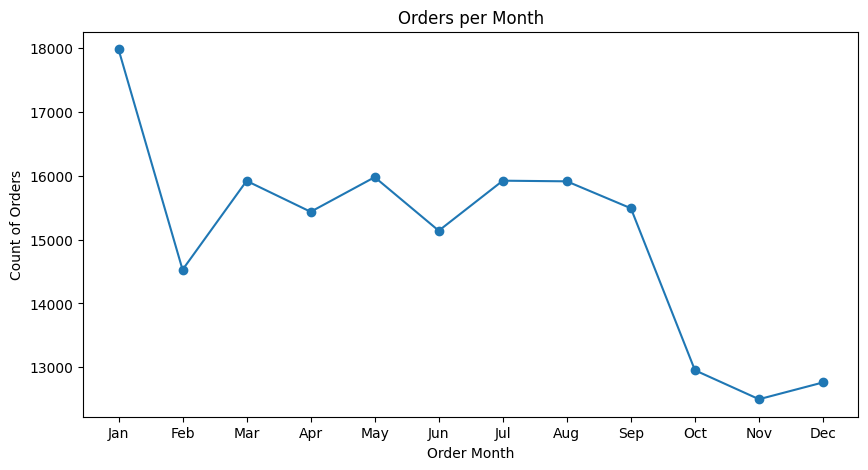

In [79]:
#Monthly seasonality trend
df['Month_Name'] = df['Order_Date'].dt.strftime('%b')

order_counts = df.groupby('Month_Name')['Order_Id'].count().reset_index()

months_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
order_counts['Month_Name'] = pd.Categorical(order_counts['Month_Name'], categories=months_order, ordered=True)
order_counts = order_counts.sort_values('Month_Name')

plt.figure(figsize=(10, 5))
plt.plot(order_counts['Month_Name'], order_counts['Order_Id'], marker='o')
plt.xlabel('Order Month')
plt.ylabel('Count of Orders')
plt.title('Orders per Month')
plt.show()

##### Product analysis
The product range includes **118** items, with *"Perfect Fitness Perfect Rip Deck"* being the top seller across all customer segments.   
Average category size is around 3,610 products, with modest variation in product prices.   A few products, like the *"SOLE E25 Elliptical"*, are **rarely** purchased.

In [80]:
#Product analysis
products = len(df['Product_Id'].unique())

product_counts = df['Product_Name'].value_counts()

category_count = df.groupby('Category_Name')['Product_Id'].count().mean()
price_count = df.groupby('Category_Name')['Product_Price'].mean()

avg_items = df['Item_Quantity'].mean()

customer_products = df.groupby('Customer_Segment')['Product_Name'].agg(lambda x: x.value_counts().idxmax())

print(f'Total number of products: {products}\n')
print(f'The most popular product "{product_counts.idxmax()}" was purchased {product_counts.max()} times\n')
print(f'The least popular product {product_counts.idxmin()} was purchased {product_counts.min()} times\n')
print(f'Average number of products in each category: {category_count}\n')
print(f'The average product price per category: {avg_items}\n')
print(f'The most popular product in each segment\n{customer_products}')

Total number of products: 118

The most popular product "Perfect Fitness Perfect Rip Deck" was purchased 24512 times

The least popular product SOLE E25 Elliptical was purchased 10 times

Average number of products in each category: 3610.18

The average product price per category: 2.127639065088167

The most popular product in each segment
Customer_Segment
Consumer       Perfect Fitness Perfect Rip Deck
Corporate      Perfect Fitness Perfect Rip Deck
Home Office    Perfect Fitness Perfect Rip Deck
Name: Product_Name, dtype: object


#### Financial insights

##### Profit Margin
Profit margins are relatively uniform (~11–12%) across all markets, customer segments, and payment types. Differences in total profit arise primarily from *differences in order volume* rather than individual *order profitability*.

In [81]:
#Profit margin in different categories
df['Profit_Margin'] = df['Profit_Capped'] / df['Sales'] * 100

market_margin = df.groupby('Market')['Profit_Margin'].mean().round(2)
segment_margin = df.groupby('Customer_Segment')['Profit_Margin'].mean().round(2)
payment_margin = df.groupby('Payment_Type')['Profit_Margin'].mean().round(2)

print("Profit margin by Market:")
for market, margin in market_margin.items():
    print(f"  {market}: {margin:.2f}%")

print("\nProfit margin by Customer Segment:")
for segment, margin in segment_margin.items():
    print(f"  {segment}: {margin:.2f}%")

print("\nProfit margin by Payment Type:")
for payment, margin in payment_margin.items():
    print(f"  {payment}: {margin:.2f}%")

Profit margin by Market:
  Africa: 11.71%
  Europe: 11.41%
  LATAM: 11.28%
  Pacific Asia: 10.83%
  USCA: 11.34%

Profit margin by Customer Segment:
  Consumer: 11.31%
  Corporate: 11.26%
  Home Office: 11.08%

Profit margin by Payment Type:
  CASH: 11.71%
  DEBIT: 11.20%
  PAYMENT: 11.12%
  TRANSFER: 11.25%


##### Correlations
- **Profit vs GDP**   
*No* linear relationship, the co-movement is weak (0.002)  
- **GDP vs Order count **  
*Moderate positive* correlation (0.652). Countries with higher GDP tend to place more orders.  
- **Order year vs Order count**  
Essentially *no* monotonic trend over time (-0.016). Order volumes did not consistently increase or decrease across years.   
- **Shipping Mode vs Delay Days**  
*Moderate negative* correlation (-0.352). Faster shipping modes (lower rank) correspond to shorter delays, confirming that shipping method is a key factor in delivery performance.  
- **Shippinh Mode vs Order count**  
*No* correlation (-0.004). The choice of shipping mode is independent of how many orders a country places.

In [82]:
mode_ranking = {'Same Day': 1, 'First Class': 2, 'Second Class': 3, 'Standard Class': 4}

def to_rank(df, var, ranking_dict=None, ascending=True):
    if ranking_dict:
        return df[var].map(ranking_dict)
    else:
        return df[var].rank(method='first', ascending=ascending)

df['Order_Year'] = pd.to_numeric(df['Order_Year'], errors='coerce')
df['Order_by_Country'] = df.groupby('ISO3')['Order_Id'].transform('count')

#Create rank columns
df['Order_Year_rank'] = to_rank(df, 'Order_Year')
df['Shipping_Mode_rank'] = to_rank(df, 'Shipping_Mode', ranking_dict=mode_ranking)

# Correlations
r1 = df['Profit_Capped'].corr(df['GDP_per_capita'], method='pearson')
r2 = df['GDP_per_capita'].corr(df['Order_by_Country'], method='pearson')
r3 = df['Order_Year_rank'].corr(df['Order_by_Country'], method='spearman')
r4 = df['Shipping_Mode_rank'].corr(df['Delay_Days'], method='spearman')
r5 = df['Shipping_Mode_rank'].corr(df['Order_by_Country'], method='spearman')

print(f"Profit vs GDP (Pearson): {r1:.3f}")
print(f"GDP vs Order count (Pearson): {r2:.3f}")
print(f"Order Year vs Order count (Spearman): {r3:.3f}")
print(f"Shipping Mode vs Delay Days (Spearman): {r4:.3f}")
print(f"Shipping Mode vs Order count (Spearman): {r5:.3f}")

Profit vs GDP (Pearson): 0.002
GDP vs Order count (Pearson): 0.652
Order Year vs Order count (Spearman): -0.016
Shipping Mode vs Delay Days (Spearman): -0.352
Shipping Mode vs Order count (Spearman): -0.004


##### Lorenz Curves
- **Profit concentration by country**  
The Lorenz curve is bowed far from the equality line, indicating that a small amount of countries account for a large portion of total profit. The **Gini Index** of 80.8% means **high concentration** in profit distribution.  
- **Order concentration by country**  
The Lorenz curve shows how orders are distributed across countries. The curve is **extremely bowed**, showing that orders are spread among countries very much. The **Gini Index** of 94.8% proves that point.  
- **GDP per capita concentration**  
The Lorenz curve for GDP per capita compares the distribution of GDP per capita across countries. This curve is less bowed compared to other Lorenz curves, with **Gini Index** of 64.3% indicating **moderate** (more even) **concentration** across countries.

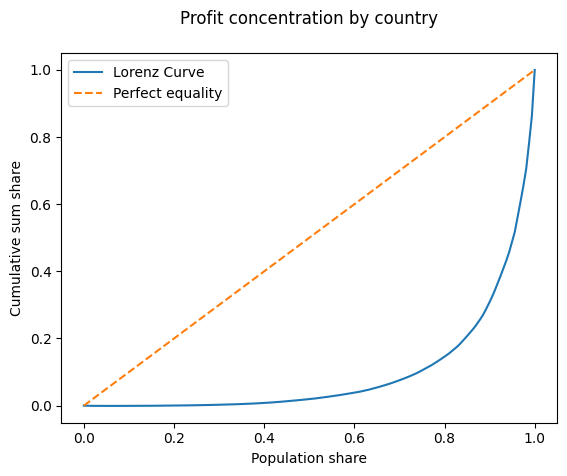

Gini index: 
80.8%


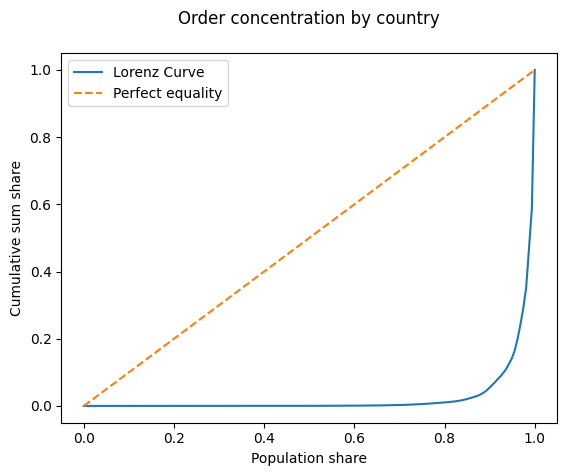

Gini index: 
94.8%


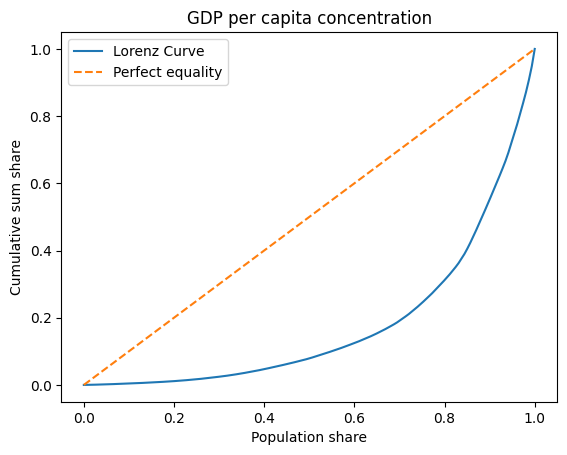

Gini index: 
64.3%


In [83]:
#Lorenz Curve

def lorenz_curve(values):
    values = np.sort(values)
    cum_values = np.cumsum(values)
    cum_share = cum_values / cum_values[-1]

    population_share = np.arange(1, len(values) + 1) / len(values)

    population_share = np.insert(population_share, 0, 0)
    cum_share = np.insert(cum_share, 0, 0)

    return population_share, cum_share

def gini(values):
    values = np.sort(values)
    z = np.cumsum(values) / np.sum(values)
    g = np.arange(1, len(values) + 1) / len(values)

    z = np.insert(z, 0, 0)
    g = np.insert(g, 0, 0)

    area = np.sum((z[1:] + z[:-1]) * (g[1:] - g[:-1]) / 2)

    return (1 - area/0.5)*100

profit_values = df.groupby('ISO3')['Profit_Capped'].sum().values
gdp_values = df.drop_duplicates('ISO3')['GDP_per_capita'].dropna().values
order_values = df.groupby('ISO3')['Order_by_Country'].sum().values

def plot_lorenz(values, title):
    g, z = lorenz_curve(values)
    gini_idx = gini(values)

    plt.figure()
    plt.plot(g, z, label='Lorenz Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect equality')
    plt.xlabel('Population share')
    plt.ylabel('Cumulative sum share')
    plt.title(title)
    plt.legend()
    plt.show()
    print(f'Gini index: \n{gini_idx:.1f}%')

plot_lorenz(profit_values, 'Profit concentration by country\n')
plot_lorenz(order_values, 'Order concentration by country\n')
plot_lorenz(gdp_values, 'GDP per capita concentration')

In [84]:
df.columns

Index(['Order_Id', 'Order_Date', 'Order_Status', 'Order_Region', 'Market',
       'ISO3', 'Customer_Segment', 'Product_Id', 'Product_Name',
       'Category_Name', 'Product_Price', 'Shipping_Date', 'Shipping_Mode',
       'Shipment(real)', 'Shipment(scheduled)', 'Delivery_Status',
       'Payment_Type', 'Item_Price', 'Item_Quantity', 'Sales', 'Profit_Capped',
       'Year', 'GDP', 'Population', 'Delay_Days', 'Delivery_Quality',
       'GDP_per_capita', 'Order_Year', 'Month_Name', 'Profit_Margin',
       'Order_by_Country', 'Order_Year_rank', 'Shipping_Mode_rank'],
      dtype='object')

In [85]:
#Drop not needed columns and save to csv
df.drop(columns=['Order_Year', 'Order_Year_rank', 'Shipping_Mode_rank', 'Order_by_Country','Month_Name'], inplace=True)

csv_file = os.path.join('transformed', 'eda.csv')
os.makedirs(os.path.dirname(csv_file), exist_ok=True)

df.to_csv(csv_file, index=False)

print(f'Data saved to {csv_file}')

Data saved to transformed\eda.csv


### Conclusion
- **Order related insights**
  - Most orders are small, but very large orders contribute disproportionately to total sales and profit.
  - The **Consumer** segment places the majority of orders, while Corporate and Home Office segments are smaller contributors.
  - **LATAM** and **Europe** generate the highest order volumes and sales, but profitability varies slightly across markets.
- **Delivery insights**
  - The most impactful factor for delivery delays is **shipping mode**.
  - Order size, GDP per capita, year, and payment type have **minimal** impact on delay duration.
- **Seasonality trends**
  - *January* shows the **peak** number of orders.
  - *March–September* demonstrates **moderate stability** in order volumes.
  - *October–December* sees a notable **drop** in orders.
- **Relationship between GDP and order indicators**
  - There is **no significant correlation** between GDP per capita and profit.
  - GDP and total order counts show a **moderate positive correlation**, indicating that higher-GDP countries tend to place more orders.
- **Profit and order concentration across countries**
  - Profit concentration is **high**: a small number of countries account for most profit.
  - Orders are widely spread across countries, indicating that many countries contribute to total orders.
  - GDP per capita shows **moderate** concentration.
- **Product popularity**
  - The most popular product across all segments is Perfect Fitness Perfect Rip Deck, while the least popular is SOLE E25 Elliptical.
  - Popularity is consistent across Consumer, Corporate, and Home Office segments.
- **Profit Margins**
  - Profit margins are relatively similar across markets.  
     
##### Summary
These insights help identify which markets, order sizes, and products generate the most value, enabling better **strategic focus and resource allocation**.   
Understanding that **shipping mode is the primary driver of delivery delays** supports operational improvements and service-level optimization.    
The analysis of **seasonality and profit concentration** highlights demand patterns and dependency on a small number of countries, which is useful for risk management and planning future growth.   
Overall, this exploration provides a reliable foundation for data-driven decisions in logistics, pricing, and market strategy.